# Data Cleaning and Normalization for Gene Expression Analysis

## This notebook outlines the steps for cleaning and normalizing a gene expression dataset. The key steps are:

1. Data Reading:
Reading the data as a dataframe in Pandas

2. Column Renaming:
This is a step done for better readability and easier data manipulation. I rename the columns to make them more understandable.

3. String Splitting:
Here, I split the Gene_ID into two separate identifiers: ENSG and HGNC. This is also a data manipulation step and is done to make the data easier to work with.

4. Data Normalization:
Normalization is performed to make the data comparable across different samples. I use Counts Per Million (CPM) normalization, which is commonly used in RNA-seq data analysis. This involves dividing each raw value by the sum of all values in its column and then multiplying by 1,000,000.

5. Data Filtering:
After normalization, I filter out genes that have a mean expression value across all samples that is less than 1. This is done to remove genes that are lowly expressed across all samples, as they are less likely to be of interest in the following analyses.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Reading the Data
# Read the raw matrix into a DataFrame
df = pd.read_csv('../data/GSE162285_gene_raw_counts_matrix.txt', delimiter='\t')
#print("Initial Data:\n")
print(df.head(2))

          ENSG|HGNC_symbol  \
0  ENSG00000223972|DDX11L1   
1   ENSG00000227232|WASH7P   

   20170417_MDAMB231Org_Veh1_ED3996-2_S1_R1_001.trimmed.fastq.gz.ReadsPerGene.out.tab  \
0                                                  0                                    
1                                                  1                                    

   20170417_MDAMB231Org_Veh2_ED3996-2_S2_R1_001.trimmed.fastq.gz.ReadsPerGene.out.tab  \
0                                                  0                                    
1                                                  2                                    

   20170417_MDAMB231Org_Veh3_ED3996-2_S3_R1_001.trimmed.fastq.gz.ReadsPerGene.out.tab  \
0                                                  0                                    
1                                                  0                                    

   20170417_MDAMB231Org_Doc1_ED3996-2_S10_R1_001.trimmed.fastq.gz.ReadsPerGene.out.tab  \
0              

**Gene Identifier and Symbol**: We can split the first column into two separate columns: one for the gene identifier (ENSG) and another for the gene symbol (HGNC_symbol).

**Sample Names**: The sample names are quite long, which makes them difficult to work with. We'll shorten these names while ensuring they remain distinguishable between control and test samples.

In [3]:
# Split the first column into two columns: 'Gene_ID' and 'Gene_Symbol'
df[['Gene_ID', 'Gene_Symbol']] = df['ENSG|HGNC_symbol'].str.split('|', expand=True)

# Drop the original combined column
df.drop('ENSG|HGNC_symbol', axis=1, inplace=True)

# Reorder columns to have 'Gene_ID' and 'Gene_Symbol' at the beginning
df = df[['Gene_ID', 'Gene_Symbol'] + [col for col in df if col not in ['Gene_ID', 'Gene_Symbol']]]

# Shorten sample names for readability
# Here, we'll use a simple strategy: keep the unique part of the sample name
df.columns = ['Gene_ID', 'Gene_Symbol'] + [col.split('_')[2] for col in df.columns[2:]]

# Display the cleaned dataset's first few rows
df.head()


,Gene_ID,Gene_Symbol,Veh1,Veh2,Veh3,Doc1,Doc2,Doc3,Veh1,Veh2,...,ED3663,ED3663,ED3663,ED3663,Veh1,Veh2,Veh3,Vinbl1,Vinbl2,Vinbl3
0,ENSG00000223972,DDX11L1,0,0,0,3,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,ENSG00000227232,WASH7P,1,2,0,2,1,0,1,0,...,0,0,4,0,0,2,0,9,6,0
2,ENSG00000278267,MIR6859-1,1,0,1,0,0,0,0,0,...,1,0,1,0,0,19,8,21,8,4
3,ENSG00000243485,,0,0,0,3,1,0,0,0,...,0,0,0,0,0,3,0,2,1,0
4,ENSG00000274890,MIR1302-2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Next, I need to normalize the gene expression values. One common method for normalization in gene expression data is the "Counts Per Million" (CPM) method. This method scales the raw counts based on the total counts in each sample, making samples comparable.

In [8]:
# Calculate the total counts for each sample (excluding the 'Gene_ID' and 'Gene_Symbol' columns)
total_counts_per_sample = df.iloc[:, 2:].sum()

# Normalize the data using CPM method
data_normalized = df.copy()
data_normalized.iloc[:, 2:] = (df.iloc[:, 2:].div(total_counts_per_sample) * 1e6)

# Display the first few rows of the normalized dataset
#data_normalized.head()

# Save newly created dataset
data_normalized.to_csv('../data/filtered_normalized_gene_expression_data.csv')

### Further step is to visualise the distribution of median gene expression values across all samples. The plot is on a logarithmic scale to better capture the wide range of expression values. All of those steps are made for better visibility and for quick data assesement.

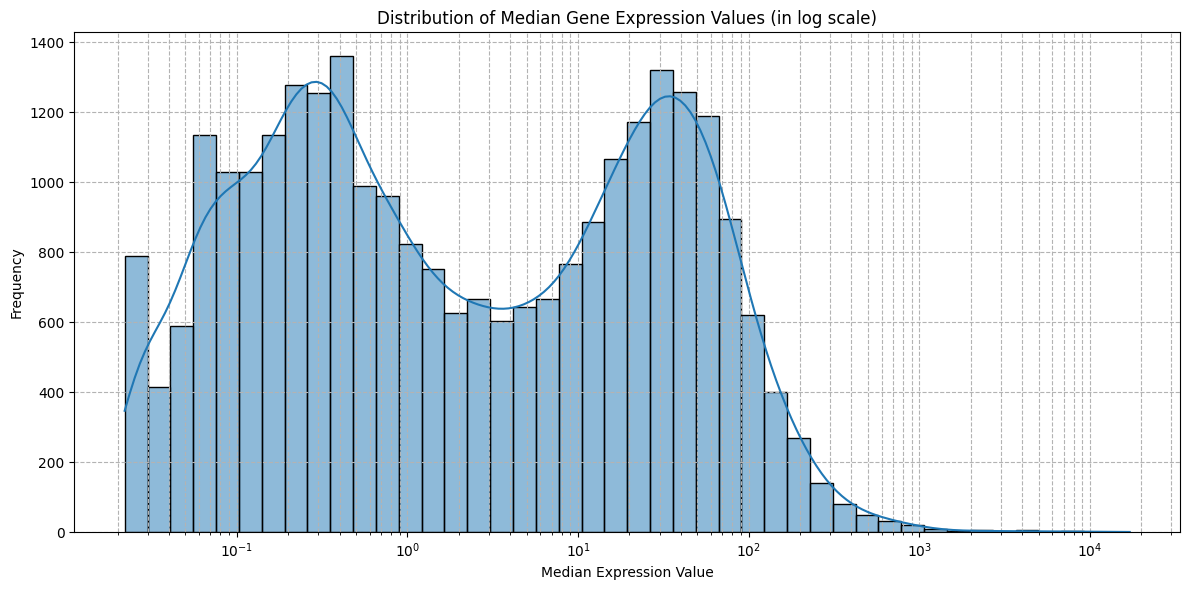

In [5]:
# Calculate median expression values across all samples for each gene
median_expression_values = data_normalized.iloc[:, 2:].median(axis=1)

# Plotting the distribution of median expression values
plt.figure(figsize=(12, 6))
sns.histplot(median_expression_values[median_expression_values > 0], log_scale=True, kde=True)
plt.title('Distribution of Median Gene Expression Values (in log scale)')
plt.xlabel('Median Expression Value')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()


Most genes have low median expression values, with a peak near the lower end of the scale.

Few genes have very high expression, leading to a long tail on the right side of the distribution.

This visualization gives an overview of the central tendency of gene expression levels across all samples.

### Next it is useful to compute the heatmap that displays the gene expression levels for the top 50 genes with the highest median expression values across all samples. The color intensity represents the expression level, with lighter shades indicating higher expression

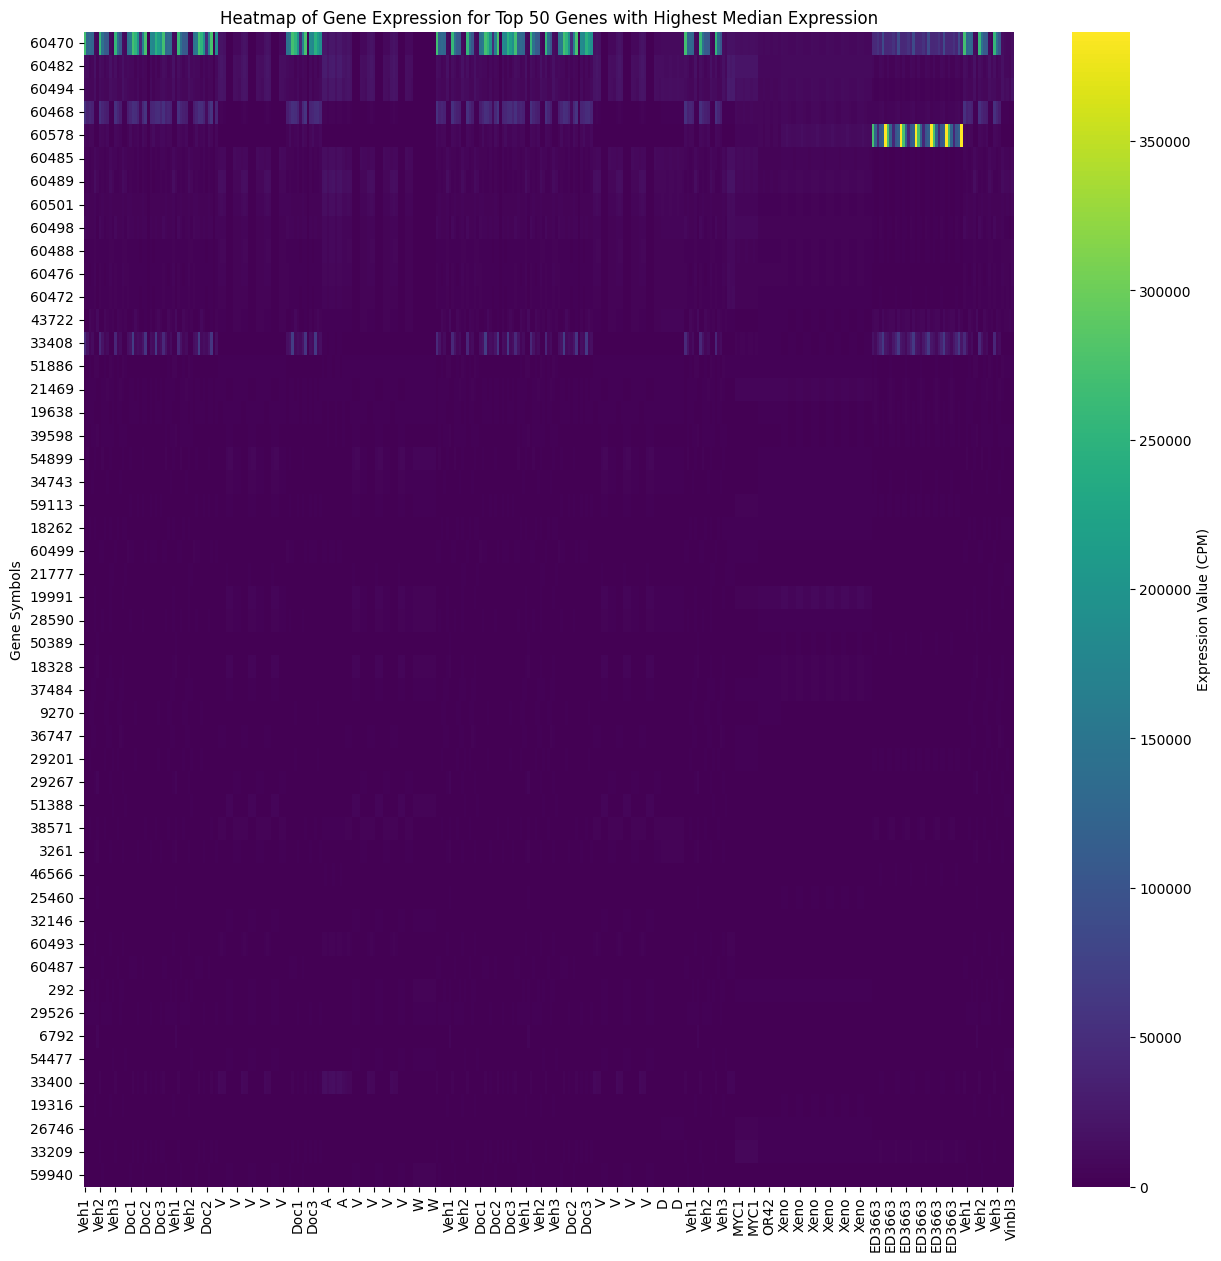

In [6]:
# Select a subset of genes with the highest median expression values for visualization
# For this example, we'll select the top 50 genes
top_genes = median_expression_values.nlargest(50).index

# Extracting data for the top genes
heatmap_data = data_normalized.loc[top_genes, data_normalized.columns[2:]]

# Plotting the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Expression Value (CPM)'})
plt.title('Heatmap of Gene Expression for Top 50 Genes with Highest Median Expression')
plt.ylabel('Gene Symbols')
plt.show()